In [1]:
'''
Program to perform 3D element analysis
Unit: mm
Author: Yitian Shao
Created on 2021.06.02
'''
%matplotlib notebook 

import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
'''
Enable fast computing using c shared library and parallel programming
'''
enableFastComputing = True;

if(enableFastComputing):
    try:
        import ctypes                     
    except:
        print("ctypes unfounded, switch to normal python computing")
        enableFastComputing = False;

    if(enableFastComputing):
        try:
            libPath = ctypes.util.find_library("./c/triangle_volume")
            triangle_volume = ctypes.CDLL(libPath)

            triangle_volume.compute.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, 
                                                ctypes.c_double, ctypes.c_double]
            triangle_volume.compute.restype = ctypes.c_double
            
            print("c shared library imported successfully!")
        except:
            print("c shared library unfounded, switch to normal python computing")
            enableFastComputing = False;


c shared library imported successfully!


In [3]:
'''
Simulation parameters 
'''
R = 50 # (mm) Radius of the sphere
c = 30 # (mm) Offset distance of the front cut from the center of the sphere
m = 17.32 # (mm) half-length of the open area of the pouch, m < r. (34.641 = sqrt(3) * 20)

w = 40 # (mm) Width of the rectangle pouch

dispAllPouch = False # Display all pouch

# For the trangle
meshDensity = int(20 * R) # density of vertices of the mesh, large value results in finer grid but larger memory demand
adPlotDensity = int(2 * R) # density of additive plot of curves and circles

# For the rectangle
# density of vertices of the mesh, large value results in finer grid but larger memory demand
meshDensity2 = int(10 * w) 
# density of additive plot of curves and circles
adPlotDensity2 = int(60 * w) 

intStepSize = 0.0001 # (mm) Step size for performing integral computation

if(dispAllPouch):
    # Display range for each axis: [xOffset, yOffset, zOffset, xScale, yScale, zScale]
    dispRange = [-w, -4 * m, 0, 7 * w, 8 * m, 4*R] 
else:
    dispRange = [0, -R, -R, 2 * R, 2 * R, 2 * R] 

dispAd = True # Display all additive sketch for better illustration
#dispAd = False

In [4]:
'''
General Functions
'''
def data_cut(x, y, z, ind):
    return x[ind], y[ind], z[ind]

def coordTrans2D(a, b, theta, a_translate, b_translate):
    # 2D coordinate transformation, rotate counter-clockwise by angle theta and then translate
    rotMat = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    ab = np.matmul(rotMat, np.stack((a, b)))
    ab[0,:] += a_translate
    ab[1,:] += b_translate
    return ab

def fitPlane2Points(p1, p2, p3):
    # Fit a plane to three nonalighed points
    return np.cross(p1 - p2, p3 - p2)

def computeCornerVolume(s, f, R, intStepSize):
    # Compute the volume of a corner of a sphere cutted by two perpendicular planes
    # 's' - radius of top cutting circle
    # 'f' - the distance between the center of front cutting circle to the center of the sphere
    # 'R' - radius of the sphere being cutted
    # 'intStepSize'- the resolution of the integral 
    a = np.arange(f**2, s**2, intStepSize)
    cornerArea = (f * np.sqrt(a - f**2) - a * np.arccos(f/np.sqrt(a))) / (2 * np.sqrt(R**2 - a))
    return -np.sum(intStepSize * cornerArea)


In [5]:
'''
Class
'''
class TrianglePouch:
    # Triangle pouch is formed by cutting front, and symmetrically two sides, then top of a sphere 
    # 'R' - radius of the sphere being cutted
    # 'c' - heigh of the triangle
    # 'm' - half width of the triangle bottom
    #  --------------------------------------
    # 'f' - distance between the center of front cutting circle to the center of the sphere
    # 's' - radius of the top cutting circle
    # 'r' - radius of the front cutting circle
    # 'h' - distance between the center of top cutting circle to the center of the sphere
    # 'n' - half length of the triangle side
    # 'intStepSize' controls the resolution of the integral
    #  --------------------------------------------------------------------------------------------------------------------
    def __init__(self, R = 50, c = 20, m = 34.641, meshDensity = 100, adPlotDensity = 100, addAd = False, dispCurve = True):
        self.R = R
        self.c = c
        self.m = m
        self.meshDensity = meshDensity
        self.adPlotDensity = adPlotDensity
        self.triangle = []
        self.frontCircle = []
        self.frontLine = []
        self.leftCircle = []
        self.leftLine = []
        self.rightCircle = []
        self.rightLine = []     
        
        
        self.beta = np.arctan(self.m/self.c) # Angle Beta (viewing from the top)
        
        self.f = 0.5 * (-m**2/c + c)
        self.s = 0.5 * (m**2/c + c)
        self.r = np.sqrt(self.R**2 - self.f**2) # Radius of the front cutting circle, r < R
        
        if(self.m >= self.r):
            print("Invalid value: m must be smaller than r")
        if(self.f < 0 or self.f >= self.R):
            print("Invalid f")
        if(self.r < self.m):
            print("Invalid r")
            
        self.h = np.sqrt(self.r**2 - self.m**2) # (mm) Cutting height of the sphere, Pouch height will be 2(r-h)
        self.alpha = np.arccos(self.h/self.r) # Angle Alpha (viewing from the front) 
        
        self.n = self.s * np.cos(self.beta)
        self.rSide = np.sqrt(self.n**2 + self.h**2)
        
        # Triangle coordinates (can be updated)
        self.triangleTopX = self.R - self.s # Note: Triangle mirror point 1
        self.triangleBottomX = self.c + self.triangleTopX # Note: Triangle mirror point 2
        self.cCenterX = self.n * np.cos(self.beta) + self.triangleTopX
        self.cCenterY = -self.n * np.sin(self.beta)
        
        # Generate the mesh of the triangle pouch
        x = np.outer(np.linspace(0, 2*R, self.meshDensity+1), np.ones(self.meshDensity+1))
        y = np.outer(np.ones(self.meshDensity+1), np.linspace(-R, R, self.meshDensity+1))
        z = R**2 - (x-R)**2 - (y**2)

        # Keep sphere upper surface
        keepInd = (z >= 0)
        x, y, z = data_cut(x, y, z, keepInd)
        z = np.sqrt(z)

        # Cut the sphere
        keepInd = (z >= self.h)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the Front Face (surface crossing the pouch)
        keepInd = (x <= self.f + self.R)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the left-side face
        pNormVector = fitPlane2Points(np.array([self.triangleTopX, 0, self.h]), 
                                      np.array([self.cCenterX, self.cCenterY, 0]), 
                                      np.array([self.triangleBottomX, -self.m, self.h]))
        keepInd = (np.matmul(pNormVector, np.stack((x - self.cCenterX, y - self.cCenterY, z))) >= 0)
        x, y, z = data_cut(x, y, z, keepInd)

        # Cut the right-side face
        pNormVector2 = fitPlane2Points(np.array([self.triangleTopX, 0, self.h]), 
                                       np.array([self.cCenterX, -self.cCenterY, 0]), 
                                      np.array([self.triangleBottomX, self.m, self.h]))
        keepInd = (np.matmul(pNormVector2, np.stack((x - self.cCenterX, y + self.cCenterY, z))) <= 0)
        x, y, z = data_cut(x, y, z, keepInd)
        
        self.triangle = np.stack((x, y, z)) # Vertex coordinate of the triangle pouch
               
        if(addAd):
            self.__additiveLine(dispCurve)
 
        print("Estimate Tri V = %.3f (mm3)" % np.sum((z - self.h) * (2*R/self.meshDensity)**2)) # Debug 
        
    def printInfo(self):
        print("r = %.2f mm, h = %.2f mm, s = %.2f mm, n = %.2f mm, rSide = %.2f mm" % (self.r, self.h, self.s, self.n,
                                                                                       self.rSide))
        print("Angle: Alpha = %.1f degree, Beta = %.1f degree" % (180*self.alpha/np.pi, 180*self.beta/np.pi))
        print("triangle with top at (%.2f, %.2f, %.2f) and left bottom at (%.2f, %.2f, %.2f)" % 
              (self.triangleTopX, 0, self.h, self.triangleBottomX, -self.m, self.h))

    # Private function for adding additive sketch for clear illustration
    def __additiveLine(self, dispCurve = True):
        # 'dispCurve' decides whether to display a curve or the entire circle
        
        # Front circle and line
        fAngle = np.linspace(0, 2*np.pi, self.adPlotDensity)
        x = (self.R + self.f) * np.ones(self.adPlotDensity)
        y = self.r * np.cos(fAngle)
        z = self.r * np.sin(fAngle)
        self.frontCircle = np.stack((x, y, z)) # Vertex coordinate of the front circle
        if(dispCurve):
            keepInd = (z >= self.h)
            self.frontCircle = self.frontCircle[:, keepInd]
        
        self.frontLine = np.array([[self.R + self.f, self.R + self.f], [-self.m, self.m],
                                   [self.h, self.h]]) # Coordinate of the front line
        
        # Side circle and line
        x, y = coordTrans2D(self.rSide * np.cos(fAngle), np.zeros(self.adPlotDensity), -self.beta, 
                            self.cCenterX, self.cCenterY)
        z = self.rSide * np.sin(fAngle)
        self.leftCircle = np.stack((x, y, z)) # Vertex coordinate of the left side circle
        if(dispCurve):
            keepInd = (z >= self.h)
            self.leftCircle = self.leftCircle[:, keepInd]
            
        self.leftLine = np.array([[self.triangleTopX, self.triangleBottomX], [0, -self.m], [self.h, self.h]])
        ###leftRadiusLine = np.array([[triangleTopX, cCenterX], [0, cCenterY], [h, 0]])# For reference only

        x, y = coordTrans2D(self.rSide * np.cos(fAngle), np.zeros(self.adPlotDensity), self.beta, 
                            self.cCenterX, -self.cCenterY)
        self.rightCircle = np.stack((x, y, z)) # Vertex coordinate of the left side circle
        if(dispCurve):
            keepInd = (z >= self.h)
            self.rightCircle = self.rightCircle[:, keepInd]
            
        self.rightLine = np.array([[self.triangleTopX, self.triangleBottomX], [0, self.m], [self.h, self.h]])
    
    # Private function for updating the coordinate of the mesh and lines
    def __updateCoordinate(self, dx = 0, dy = 0, dz = 0):
        self.triangle[0,:] += dx
        self.triangle[1,:] += dy
        self.triangle[2,:] += dz
        
        if(len(self.frontCircle)):
            self.frontCircle[0,:] += dx
            self.frontCircle[1,:] += dy
            self.frontCircle[2,:] += dz

        if(len(self.frontLine)):
            self.frontLine[0,:] += dx
            self.frontLine[1,:] += dy
            self.frontLine[2,:] += dz

        if(len(self.leftCircle)):
            self.leftCircle[0,:] += dx
            self.leftCircle[1,:] += dy
            self.leftCircle[2,:] += dz

        if(len(self.leftLine)):
            self.leftLine[0,:] += dx
            self.leftLine[1,:] += dy
            self.leftLine[2,:] += dz

        if(len(self.rightCircle)):
            self.rightCircle[0,:] += dx
            self.rightCircle[1,:] += dy
            self.rightCircle[2,:] += dz

        if(len(self.rightLine)):
            self.rightLine[0,:] += dx
            self.rightLine[1,:] += dy
            self.rightLine[2,:] += dz
        
        self.triangleTopX += dx
        self.triangleBottomX += dx
        self.cCenterX += dx
        self.cCenterY += dy
           
    def transformPouch(self, x = 0, y = 0, z = 0, flip = False):
        # Flip along the x axis
        if(flip):
            self.triangle[0,:] *= -1
            
            if(len(self.frontCircle)):
                self.frontCircle[0,:] *= -1
                
            if(len(self.frontLine)):
                self.frontLine[0,:] *= -1
                
            if(len(self.leftCircle)):
                self.leftCircle[0,:] *= -1
                
            if(len(self.leftLine)):
                self.leftLine[0,:] *= -1
                
            if(len(self.rightCircle)):
                self.rightCircle[0,:] *= -1
                
            if(len(self.rightLine)):
                self.rightLine[0,:] *= -1
                
            self.triangleTopX *= -1
            self.triangleBottomX *= -1
            self.cCenterX *= -1
            self.cCenterX *= -1
            
            # After flip, shift to align the current top to: the bottom before flipping
            self.__updateCoordinate(-self.triangleTopX -self.triangleBottomX, -self.m, 0)        
        
        # Translation
        self.__updateCoordinate(x, y, z)
        
                
    def displayPouch(self, ax, dispAdditive = False):
        ax.scatter3D(self.triangle[0,:], self.triangle[1,:], self.triangle[2,:], 
                 s = 1, edgecolor="k", facecolor="none")
        
        if(dispAdditive):
            # Additive plot
            # Plot front circle
            if(len(self.frontCircle)):
                ax.plot(self.frontCircle[0,:], self.frontCircle[1,:], self.frontCircle[2,:], c = 'g')
                
            # Plot front line
            if(len(self.frontLine)):
                ax.plot(self.frontLine[0,:], self.frontLine[1,:], self.frontLine[2,:], '--', c = 'g')
                
            # Plot left circle
            if(len(self.leftCircle)):
                ax.plot(self.leftCircle[0,:], self.leftCircle[1,:], self.leftCircle[2,:], c = 'b')
                
            # Plot left line
            if(len(self.leftLine)):
                ax.plot(self.leftLine[0,:], self.leftLine[1,:], self.leftLine[2,:], '--', c = 'b')
                
            # Plot right circle
            if(len(self.rightCircle)):
                ax.plot(self.rightCircle[0,:], self.rightCircle[1,:], self.rightCircle[2,:], c = 'b')
                
            # Plot right line
            if(len(self.rightLine)):
                ax.plot(self.rightLine[0,:], self.rightLine[1,:], self.rightLine[2,:], '--', c = 'b')
 
    def getVolume(self, intStepSize):   
        if(enableFastComputing):
            return triangle_volume.compute(triPouch0.s, triPouch0.f, triPouch0.R, triPouch0.h, triPouch0.n, intStepSize)
        
        # Normal computing when fast computing is unavailable 
        frontCornerVol = computeCornerVolume(self.s, self.f, self.R, intStepSize)

        sideCornerVol = computeCornerVolume(self.s, np.sqrt(self.s**2 - self.n**2), self.R, intStepSize)

        domeVol = ( 2 * self.R**2 * (self.R - self.h) + self.h * (self.h**2 - self.R**2) ) * np.pi/3
    
        return domeVol - frontCornerVol - 2*sideCornerVol
    
'''----------------------------------------------------------------------------------------------------------------------'''
class RectanglePouch:
    def __init__(self, r = 10, w = 50, m = 0, meshDensity = 100, adPlotDensity = 100, addAd = False, dispCurve = True):
        self.r = r
        self.w = w
        self.m = m
        self.meshDensity = meshDensity
        self.adPlotDensity = adPlotDensity
        self.frontLine = []
        self.leftLine = []
        self.rightLine = []
        
        if(m >= r):
            print("Invalid value: m must be smaller than r")
        
        self.alpha = np.arcsin(self.m/self.r) # Angle Alpha (viewing from the front) 
        self.zCut = np.sqrt(self.r**2 - self.m**2) # Supposed to be the h of the triangle pouch
        
        # Generate the mesh of the rectangle pouch
        fAngle = np.linspace(0, 2*np.pi, self.adPlotDensity+1)
        x = np.outer(np.linspace(0, self.w, self.meshDensity+1), np.ones(self.adPlotDensity+1))
        y = np.outer(np.ones(self.meshDensity+1), self.r * np.cos(fAngle))
        z = np.outer(np.ones(self.meshDensity+1), self.r * np.sin(fAngle))

        keepInd = (z >= self.zCut)
        x, y, z = data_cut(x, y, z, keepInd)
        self.rectangle = np.stack((x, y, z))

        if(addAd):
            self.__additiveLine(dispCurve)
            
        print("Estimate Rect V = %.3f (mm3)" % np.sum((z - self.zCut) * (self.w/self.meshDensity)**2)) # Debug 
    
    # Private function for adding additive sketch for clear illustration
    def __additiveLine(self, dispCurve = True):
        # 'dispCurve' decides whether to display a curve or the entire circle
        fAngle = np.linspace(0, 2*np.pi, self.adPlotDensity)
        x = self.w * np.ones(self.adPlotDensity)
        y = self.r * np.cos(fAngle)
        z = self.r * np.sin(fAngle)
        self.frontCircle = np.stack((x, y, z))
        
        if(dispCurve):
            keepInd = (z >= self.zCut)
            self.frontCircle = self.frontCircle[:, keepInd]
        
        # Coordinate of the front line
        self.frontLine = np.array([[self.w, self.w], [-self.m, self.m], [self.zCut, self.zCut]]) 
        # Coordinate of the left line
        self.leftLine = np.array([[0, self.w], [-self.m, -self.m], [self.zCut, self.zCut]]) 
        # Coordinate of the right line
        self.rightLine = np.array([[0, self.w], [self.m, self.m], [self.zCut, self.zCut]]) 
        
    
    def transformPouch(self, dx = 0, dy = 0, dz = 0):
        self.rectangle[0,:] += dx
        self.rectangle[1,:] += dy
        self.rectangle[2,:] += dz
        
        if(len(self.frontCircle)):
            self.frontCircle[0,:] += dx
            self.frontCircle[1,:] += dy
            self.frontCircle[2,:] += dz

        if(len(self.frontLine)):
            self.frontLine[0,:] += dx
            self.frontLine[1,:] += dy
            self.frontLine[2,:] += dz

        if(len(self.leftLine)):
            self.leftLine[0,:] += dx
            self.leftLine[1,:] += dy
            self.leftLine[2,:] += dz

        if(len(self.rightLine)):
            self.rightLine[0,:] += dx
            self.rightLine[1,:] += dy
            self.rightLine[2,:] += dz
            
    def displayPouch(self, ax, dispAdditive = False):
        ax.scatter3D(self.rectangle[0,:], self.rectangle[1,:], self.rectangle[2,:], 
                         s = 1, edgecolor="k", facecolor="none")
        
        if(dispAdditive):
            # Additive plot
            # Plot front circle
            if(len(self.frontCircle)):
                ax.plot(self.frontCircle[0,:], self.frontCircle[1,:], self.frontCircle[2,:], c = 'g')
                
            # Plot front line
            if(len(self.frontLine)):
                ax.plot(self.frontLine[0,:], self.frontLine[1,:], self.frontLine[2,:], '--', c = 'g')
                
            # Plot left line
            if(len(self.leftLine)):
                ax.plot(self.leftLine[0,:], self.leftLine[1,:], self.leftLine[2,:], c = 'r')
                
            # Plot right line
            if(len(self.rightLine)):
                ax.plot(self.rightLine[0,:], self.rightLine[1,:], self.rightLine[2,:], c = 'r')
    
    def getVolume(self): 
        return (self.alpha * self.r**2 - self.zCut * self.m) * self.w


<IPython.core.display.Javascript object>


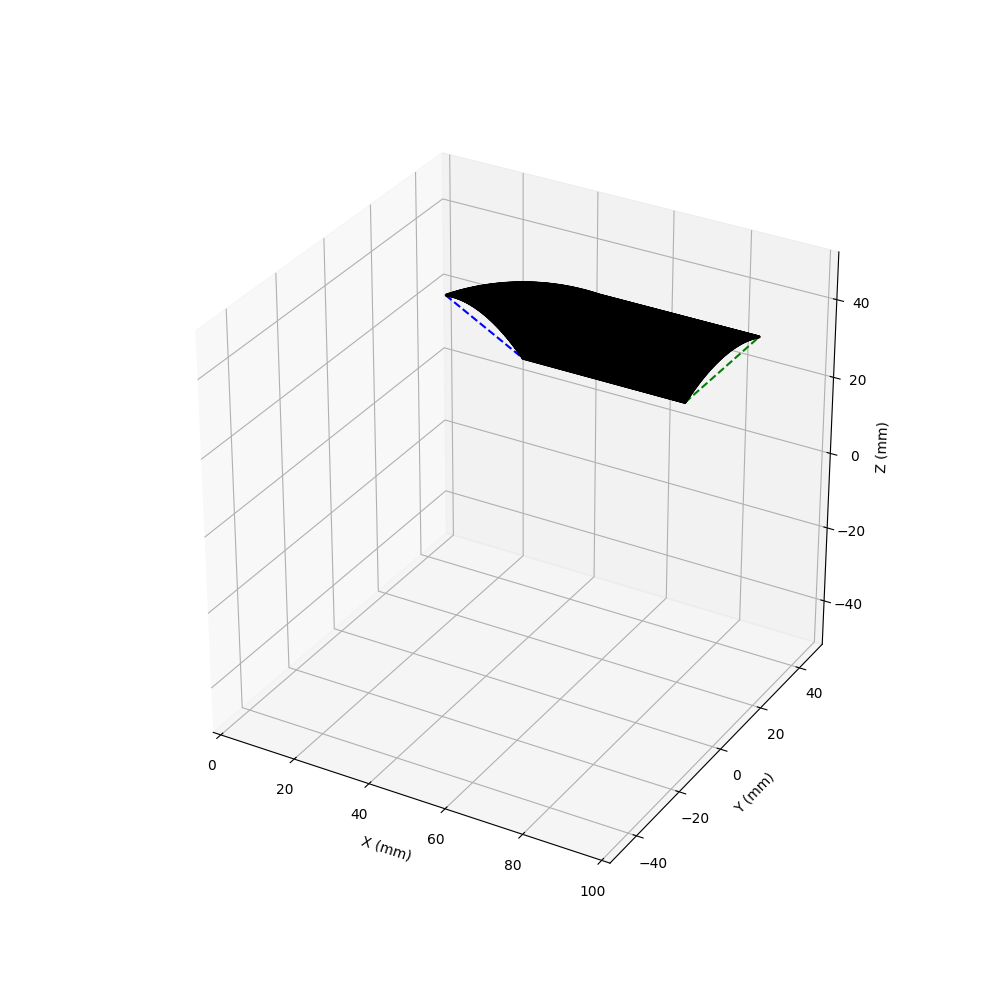

Estimate Tri V = 1644.254 (mm3)
r = 48.99 mm, h = 45.83 mm, s = 20.00 mm, n = 17.32 mm, rSide = 48.99 mm
Angle: Alpha = 20.7 degree, Beta = 30.0 degree
triangle with top at (30.00, 0.00, 45.83) and left bottom at (60.00, -17.32, 45.83)
Estimate Rect V = 2329.758 (mm3)


In [6]:
'''
Plot entire pouch
'''
# Initialize a figure
fig1 = plt.figure(figsize = (10,10))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_xlim3d([dispRange[0], dispRange[0] + dispRange[3]])
ax.set_ylim3d([dispRange[1], dispRange[1] + dispRange[4]])
ax.set_zlim3d([dispRange[2], dispRange[2] + dispRange[5]])
ax.set_box_aspect([dispRange[3], dispRange[4], dispRange[5]])
plt.show()

if(dispAllPouch):
    # Generate Triange Pouch: Row 1
    triPouch0 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd, dispCurve = False)
    triPouch0.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch0.printInfo()
    triPouch1 = TrianglePouch(R, c, m, meshDensity)
    triPouch1.transformPouch(0, 0, 0, flip = True) # Flip odd number triangle
    triPouch1.displayPouch(ax)                      # Plot the triangle pouch

    triPouch2 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch2.transformPouch(0, -2 * m, 0)
    triPouch2.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch3 = TrianglePouch(R, c, m, meshDensity)
    triPouch3.transformPouch(0, -2 * m, 0, flip = True) # Flip odd number triangle
    triPouch3.displayPouch(ax)                      # Plot the triangle pouch

    triPouch4 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch4.transformPouch(0, 2 * m, 0)
    triPouch4.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch5 = TrianglePouch(R, c, m, meshDensity)
    triPouch5.transformPouch(0, 2 * m, 0, flip = True) # Flip odd number triangle
    triPouch5.displayPouch(ax)                      # Plot the triangle pouch

    triPouch7 = TrianglePouch(R, c, m, meshDensity)
    triPouch7.transformPouch(0, 4 * m, 0, flip = True) # Flip odd number triangle
    triPouch7.displayPouch(ax)                      # Plot the triangle pouch

    # Generate Rectangle Pouch: Row 2
    rectPouch0 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch0.transformPouch(triPouch0.triangleBottomX, 0, 0)
    rectPouch0.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    rectPouch1 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch1.transformPouch(triPouch0.triangleBottomX, -2 * m, 0)
    rectPouch1.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    rectPouch2 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch2.transformPouch(triPouch0.triangleBottomX, 2 * m, 0)
    rectPouch2.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    # Generate Rectangle Pouch: Row 0
    rectPouch3 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch3.transformPouch(triPouch0.triangleTopX - w, -m, 0)
    rectPouch3.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    rectPouch4 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch4.transformPouch(triPouch0.triangleTopX - w, -3 * m, 0)
    rectPouch4.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    rectPouch5 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch5.transformPouch(triPouch0.triangleTopX - w, m, 0)
    rectPouch5.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    rectPouch6 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch6.transformPouch(triPouch0.triangleTopX - w, 3 * triPouch0.m, 0)
    rectPouch6.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    # Generate Triange Pouch: Row 3
    triPouch8 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch8.transformPouch(triPouch0.c + w, m, 0)
    triPouch8.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch9 = TrianglePouch(R, c, m, meshDensity)
    triPouch9.transformPouch(triPouch0.c + w, m, 0, flip = True) # Flip odd number triangle
    triPouch9.displayPouch(ax)                      # Plot the triangle pouch

    triPouch10 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch10.transformPouch(triPouch0.c + w, -m, 0)
    triPouch10.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch11 = TrianglePouch(R, c, m, meshDensity)
    triPouch11.transformPouch(triPouch0.c + w, -m, 0, flip = True) # Flip odd number triangle
    triPouch11.displayPouch(ax)                      # Plot the triangle pouch

    triPouch13 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch13.transformPouch(triPouch0.c + w, 3 * m, 0, flip = True)
    triPouch13.displayPouch(ax) # Plot the triangle pouch

    # Generate Rectangle Pouch: Row 4
    rectPouch7 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch7.transformPouch(triPouch0.triangleBottomX + triPouch0.c + w, -m, 0)
    rectPouch7.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    rectPouch8 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch8.transformPouch(triPouch0.triangleBottomX + triPouch0.c + w, m, 0)
    rectPouch8.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch

    # Generate Triange Pouch: Row 5
    triPouch14 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch14.transformPouch(2 * (triPouch0.c + w), 0, 0)
    triPouch14.displayPouch(ax, dispAdditive = True) # Plot the triangle pouch
    triPouch15 = TrianglePouch(R, c, m, meshDensity)
    triPouch15.transformPouch(2 * (triPouch0.c + w), 0, 0, flip = True) # Flip odd number triangle
    triPouch15.displayPouch(ax)                      # Plot the triangle pouch

    triPouch17 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch17.transformPouch(2 * (triPouch0.c + w), 2 * m, 0, flip = True)
    triPouch17.displayPouch(ax) # Plot the triangle pouch

    # Generate Rectangle Pouch: Row 6
    rectPouch9 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch9.transformPouch(triPouch0.triangleBottomX + 2 * (triPouch0.c + w), 0, 0)
    rectPouch9.displayPouch(ax, dispAdditive = dispAd) # Plot the rectangle pouch
else:
    # Display only one triangle and one rectangle pouch
    triPouch0 = TrianglePouch(R, c, m, meshDensity, addAd = dispAd)
    triPouch0.displayPouch(ax, dispAdditive = True) 
    triPouch0.printInfo()
    
    rectPouch0 = RectanglePouch(triPouch0.r, w, triPouch0.m, meshDensity2, adPlotDensity2, addAd = True)
    rectPouch0.transformPouch(triPouch0.triangleBottomX, 0, 0)
    rectPouch0.displayPouch(ax, dispAdditive = dispAd) 
    

In [7]:
'''
Comput volume by boolean subtraction for validation purpose
'''
time0 = time.time()
triV = triPouch0.getVolume(intStepSize)
print("Volume of the triangle pouch V = %.3f mm3 (Computed in %.10f sec)" % (triV, time.time()-time0)) 

rectV = rectPouch0.getVolume()
print("Volume of the rectangle pouch V = %.3f mm3" % rectV) 


Volume of the triangle pouch V = 1640.606 mm3 (Computed in 0.0828034878 sec)
Volume of the rectangle pouch V = 2941.966 mm3
